# Twitter data analysis project
## Data exploration

The purpose of this notebook is to explore the data to extract any meaningful information we can share with the stakeholders.<br>
For the part of the data exploration, we decide to provide some information about the shape of the data we extracted from the JSON file named *global_twitter_data.json*. Those information are:
* shape of the data frame
* distribution of the languages (number of occurence of the tweets languages)
* the most used hashtags
* the general opinion of tweetos
* whether we can trust or not the information conveyed by the tweets
* the most used words

In [26]:
# Import the libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys,os
import seaborn as sns
from wordcloud import STOPWORDS,WordCloud
from gensim import corpora
import pandas as pd
import statistics
import string

sys.path.append(os.path.abspath(os.path.join('../')))

# Import the modules
from clean_tweets_dataframe import Clean_Tweets

# Import the data set
df = pd.read_csv("../data/processed_tweet_data.csv")

In [27]:
# Look at the information about the data set
print(df.shape)
df.info()

(22000, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22000 entries, 0 to 21999
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   created_at          22000 non-null  object 
 1   source              22000 non-null  object 
 2   original_text       22000 non-null  object 
 3   clean_text          22000 non-null  object 
 4   polarity            22000 non-null  float64
 5   subjectivity        22000 non-null  float64
 6   sentiment           22000 non-null  object 
 7   lang                22000 non-null  object 
 8   favorite_count      22000 non-null  int64  
 9   retweet_count       22000 non-null  int64  
 10  original_author     22000 non-null  object 
 11  followers_count     22000 non-null  int64  
 12  friends_count       22000 non-null  int64  
 13  possibly_sensitive  6191 non-null   object 
 14  hashtags            22000 non-null  object 
 15  user_mentions       22000 non-null  objec

We have $22000$ tweets in our data set and $17$ features.

In [34]:
# Get the text category (positive, negative, neutral)
def text_category(polarity):
    """
    Description:
    ------------
    Function to return sentiment carried out by a tweet (using it's polarity)
    """
    if polarity < 0:
        return('negative')
    elif polarity >0:
        return('positive')
    else:
        return('neutral')

# Plot the repartition of the languages
def plot_bar(df,col:str):
    """
    Description:
    ------------
    Draw bar plot based on the column 'col' in the dataframe 'df'
    """
    plt.bar(df[col].value_counts().index,df[col].value_counts())
    plt.show()

# Extract elements
def extract_el(df,col,num_el=5):
    """
    Description:
    ------------
    Extract
    """
    res = pd.DataFrame(df[col].value_counts()[:num_el])
    return res

In [36]:
extract_el(df,'original_author',10)

,original_author
TrumpThuan,116
CGMeifangZhang,65
AarianNewsX,59
Lin73324756,48
Bin20211001,46
YangChenbin,45
Alex28807650,44
SoizaDavid,42
fchaumac_chau,41
hephaistos_ai,39


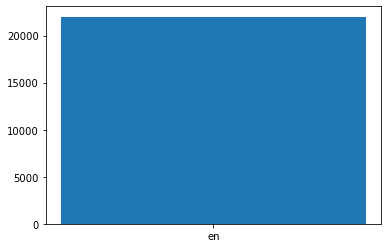

In [29]:
plot_bar(df,'lang')

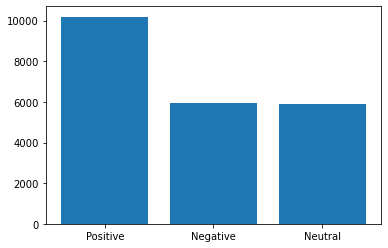

In [30]:
plot_bar(df,'sentiment')

In [32]:
df['original_author'].value_counts()

TrumpThuan         116
CGMeifangZhang      65
AarianNewsX         59
Lin73324756         48
Bin20211001         46
                  ... 
RomeshNadir          1
BlackberryXRP        1
damnsleeper          1
o0LXQCUdfQYHftW      1
TTrapczynski         1
Name: original_author, Length: 13433, dtype: int64

In [3]:
# Clean the tweets
dfObj = Clean_Tweets(df)
dfObj.drop_duplicate()
dfObj.drop_unwanted_column()
dfObj.convert_to_datetime('created_at')
dfObj.convert_to_numbers()
dfClean = dfObj.remove_non_english_tweets()

Automation in Action...!!!


In [4]:
dfClean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22000 entries, 0 to 21999
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   created_at          22000 non-null  datetime64[ns, UTC]
 1   source              22000 non-null  object             
 2   original_text       22000 non-null  object             
 3   clean_text          22000 non-null  object             
 4   polarity            22000 non-null  float64            
 5   subjectivity        22000 non-null  float64            
 6   sentiment           22000 non-null  object             
 7   lang                22000 non-null  object             
 8   favorite_count      22000 non-null  int64              
 9   retweet_count       22000 non-null  int64              
 10  original_author     22000 non-null  object             
 11  followers_count     22000 non-null  int64              
 12  friends_count       22000 non-nu

In [15]:
plt.line(dfClean['date'].value_counts().index,dfClean['date'].value_counts())

AttributeError: module 'matplotlib.pyplot' has no attribute 'line'